In [15]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import math
import utils2
import pandas as pd
import pickle
import libfmp.c6, libfmp.b
import warnings
from matplotlib.font_manager import FontProperties
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.lines import Line2D
from scipy.interpolate import make_interp_spline
from scipy.interpolate import Akima1DInterpolator
from itertools import groupby
import parselmouth
import scipy
from scipy.signal import savgol_filter
import copy
import crepe
import sys

from pydub import AudioSegment, silence
from pydub.playback import play
import soundfile as sf
from praatio import tgio
import soundfile as sf

import ipywidgets as widgets
import IPython.display as ipd
from IPython.display import display, clear_output

import expressiveness_measure_new
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
from Levenshtein import distance as levenshtein_distance  # pip install python-Levenshtein
import Levenshtein

# Ignore all warnings
warnings.filterwarnings("ignore")




In [16]:
parent_dir = os.path.dirname(os.getcwd())
base_folder = os.path.join(parent_dir, 'All_audio_files_16kHz')

In [17]:
bandish = "ja_jare"

In [18]:
eng_dict = {
    "जा1": "Jaa1", "जा2": "Jaa2", "रे": "Re", "अ": "A", "प": "Pa", "ने": "Ne", "मं": "Man",
    "दि1": "di1", "र": "Ra", "वा": "Waa", "सु": "Su", "न1": "Na1", "पा": "Paa", "वे": "We",
    "गी": "Gii", "सा": "Saa", "स": "Sa", "न2": "Na2", "न3": "Na3", "दि2": "di2", "या": "Yaa",
    "न4": "Na4", "हो": "Ho", "दा": "daa", "रं": "Ran", "ग": "Ga", "तु": "tu", "म": "Ma",
    "को": "Ko", "चा": "Chaa", "ह": "Ha", "त": "ta", "हैं": "Hain", "क्या": "Kyaa",
    "छ": "Chha", "न5": "Na5", "दि3": "di3", "s": "-", "२": "2", "३": "3",
    "ए": "Ye", "री1": "Rii1", "आ": "Aa", "ली": "Lii", "पि1": "Pi1", "या1": "Yaa1",
    "बि": "Bi", "पि": "Pi", "न": "Na", "री": "Rii", "खी": "Khi", "क": "Ka",
    "ल": "La", "ना": "Naa", "मो": "Mo", "हे": "He", "घ": "Gha", "जि": "Ji",
    "दी": "dii", "ज": "Ja", "ब": "Ba", "से": "Se", "दे": "de", "श": "Sha",
    "व": "Wa", "की": "Kii", "नो": "No", "ति": "ti", "याँ": "Yaan", "ट": "Ta",
    "ता": "taa", "गि": "Gi"
}

In [19]:
folder = "bhimpalasi_ja_jare"
artists = ["ABD", "AC", "AK", "DG", "IN", "KS", "MB", "NG", "PB", "PT", "PTJ", "RK", "RV", "SA", "SZ"] 
syl_list = ["जा1", "जा2", "रे", "अ", "प", "ने", "मं", "दि1", "र", "वा"]
id_list = ["C1L1B7", "C1L2B9", "C1L2B11", "C1L2B13", "C1L2B14", "C1L2B15", "C2L1B1", "C2L1B3", "C2L1B4", "C2L1B5"]
syl_id_dict = dict(zip(id_list, syl_list))
sr_nov = 100

In [20]:
# folder = "yaman_yeri_aali"
# artists = ["ABD", "AC", "IN", "JV", "KA", "KA2", "KS", "MB", "RH", "SA", "SHS", "SS", "SZ"]
# syl_list = ["स", "खी", "ए", "री1", "आ", "ली", "पि1", "या1", "बि", "न1"]
# id_list = ["C2L1B7", "C2L1B8", "C1L2B9", "C1L2B11", "C1L2B13", "C1L2B15", "C2L1B1", "C2L1B2", "C2L1B3", "C2L1B4"]
# syl_id_dict = dict(zip(id_list, syl_list))
# sr_nov = 100

In [21]:
def merge_by_syllable_first_key(og_data, id_list, syl_list):
    data = copy.deepcopy(og_data)

    syl_lab_dict = dict(zip(syl_list, id_list))
    merged_dict = {key: [] for key in id_list}

    label_map_no_NA = [line for lines in data.values() for line in lines]
    # sorted_label_map
    sorted_label_map = sorted(label_map_no_NA, key=lambda x: x[0][0])
    for line in sorted_label_map:
        syllable = line[1][2]
        # print(syllable)
        if syllable in syl_lab_dict:
            id = syl_lab_dict[syllable]
            merged_dict[id].append(line)

    return merged_dict

# observations_per_id = merge_by_syllable_first_key(observations_per_id, id_list, syl_list) 
    

In [22]:
bandish_db = os.path.join(base_folder, 'Bandish_Database.xlsx')

def get_tonic_from_excel(bandish_db, file_name, sheet_name=bandish):
    df = pd.read_excel(bandish_db, sheet_name=sheet_name, skiprows=5)
    match = df[df["Recording name"] == file_name]

    if match.empty or "Tonic" not in df.columns:
        raise ValueError(f"Tonic not found for '{file_name}' or missing 'tonic' column.")
    df
    return match["Tonic"].iloc[0]

#Standard Tuning: A4 = 440Hz

def get_frequency(tonic):
    return librosa.note_to_hz(tonic)

def get_segments(times, quantized):
    segments = []
    start = times[0]
    prev = quantized[0]

    for t, q in zip(times[1:], quantized[1:]):
        if q != prev:
            if prev != -np.inf:
                segments.append((start, t, prev))
            start = t
            prev = q

    if prev != -np.inf:
        segments.append((start, times[-1], prev))
    return segments

def quantize_pitch_contour(pitch_cents, bins_cents):
    """
    Quantizes a pitch contour (in cents) to the nearest value from a list of bins.

    Parameters:
        pitch_cents (np.ndarray): Array of pitch values in cents. Can contain -np.inf for unvoiced.
        bins_cents (list or np.ndarray): List of bin center values in cents.

    Returns:
        np.ndarray: Quantized pitch contour with -inf preserved for unvoiced.
    """
    bins = np.array(bins_cents)
    quantized = np.copy(pitch_cents)

    # Mask for voiced regions
    voiced_mask = (pitch_cents != -np.inf)

    # For each voiced pitch, find the nearest bin
    voiced_vals = pitch_cents[voiced_mask]
    nearest_bins = bins[np.argmin(np.abs(voiced_vals[:, np.newaxis] - bins), axis=1)]

    quantized[voiced_mask] = nearest_bins

    return quantized


In [23]:
note_labels_hin = ["स़ा", "ऱे्", "ऱे", "ग़्", "ग़", "म़", "म़॑", "प़", "ध़्", "ध़", "ऩि्", "ऩि",
                "सा", "रे्", "रे", "ग्", "ग", "म", "म॑", "प", "ध्", "ध", "नि्", "नि", 
                "सां", "रे्ं ", "रें", "ग्ं", "गं", "मं", "मं॑", "पं"]

note_labels_eng = ["'S", "'r", "'R", "'g", "'G", "'m", "'M", "'P", "'d", "'D", "'n", "'N",
                "S", "r", "R", "g", "G", "m", "M", "P", "d", "D", "n", "N",
                "S'", "r'", "R'", "g'", "G'", "m'", "M'", "P'"]


note_ratios = np.array([
    1/2, 1/2 * 16/15, 1/2 * 9/8, 1/2 * 6/5, 1/2 * 5/4, 1/2 * 4/3, 1/2 * 45/32, 1/2 * 3/2, 1/2 * 8/5, 1/2 * 5/3, 1/2 * 9/5, 1/2 * 15/8,
    1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8,
    2, 2 * 16/15, 2 * 9/8, 2 * 6/5, 2 * 5/4, 2 * 4/3, 2 * 45/32, 2 * 3/2
])

# note_ratios_round = np.round(note_ratios*tonic_freq, decimals=2)

if "ja_jare" in bandish:
    note_indices = [0, 2, 3, 5, 7, 9, 10, 12, 14, 15, 17, 19, 21, 22, 24, 26, 27, 29, 31]
    note_cents_eq = [-1200, -1000, -900, -700, -500, -300, -200, 0, 200, 300, 500, 700, 900, 1000, 1200, 1400, 1500, 1700, 1900]
    note_cents_just = 1200 * np.log2(note_ratios[note_indices])
    raga_cent_labels = ["स़ा", "ऱे", "ग़्", "म़", "प़", "ध़", "ऩि्", "सा", "रे", "ग्", "म", "प", "ध", "नि्", "सां", "रें", "ग्ं", "मं", "पं"]
    raga_cent_labels_eng = ["'S", "'R", "'g", "'m", "'P", "'D", "'n", "S", "R", "g", "m", "P", "D", "n", "S'", "R'", "g'", "m'", "P'"]
    raga_cent_labels_dict = dict(zip(raga_cent_labels, raga_cent_labels_eng))
elif "yeri_aali" in bandish:
    note_indices = [0, 2, 4, 6, 7, 9, 11, 12, 14, 16, 18, 19, 21, 23, 24, 26, 28, 30, 31]
    note_cents_eq = [-1200, -1100, -900, -700, -600, -400, -200, 0, 200, 400, 600, 700, 900, 1100, 1200, 1400, 1500, 1700, 1900]
    note_cents_just = 1200 * np.log2(note_ratios[note_indices])
    raga_cent_labels = ["स़ा", "ऱे", "ग़", "म़॑", "प़", "ध़", "ऩि", "सा", "रे", "ग", "म॑", "प", "ध", "नि", "सां", "रें", "गं", "मं॑", "पं"]
    raga_cent_labels_eng = ["'S", "'R", "'G", "'M", "'P", "'D", "'N", "S", "R", "G", "M", "P", "D", "N", "S'", "R'", "G'", "M'", "P'"]
    raga_cent_labels_dict = dict(zip(raga_cent_labels, raga_cent_labels_eng))

for i, j, k in zip(note_cents_just, note_cents_eq, raga_cent_labels):
    print(i,"\t", j,k )


-1200.0 	 -1200 स़ा
-996.0899982692251 	 -1000 ऱे
-884.3587129994474 	 -900 ग़्
-701.9550008653875 	 -700 म़
-498.04499913461257 	 -500 प़
-315.64128700055255 	 -300 ध़
-182.40371213405993 	 -200 ऩि्
0.0 	 0 सा
203.91000173077484 	 200 रे
315.64128700055255 	 300 ग्
498.0449991346125 	 500 म
701.9550008653874 	 700 प
884.3587129994474 	 900 ध
1017.5962878659401 	 1000 नि्
1200.0 	 1200 सां
1403.9100017307749 	 1400 रें
1515.6412870005524 	 1500 ग्ं
1698.0449991346125 	 1700 मं
1901.9550008653873 	 1900 पं


In [24]:
#pitch contour interpolation

def interpolate_short_unvoiced_gaps(f0, max_gap_frames=7):
    f0 = np.array(f0, dtype=float)
    voiced_mask = (f0 > 0) & ~np.isnan(f0)
    unvoiced_mask = ~voiced_mask

    f0_interp = f0.copy()
    start = 0

    while start < len(f0):
        if unvoiced_mask[start]:
            end = start
            while end < len(f0) and unvoiced_mask[end]:
                end += 1
            gap_length = end - start

            # Interpolate only if short gap and surrounded by voiced
            if start > 0 and end < len(f0) and gap_length <= max_gap_frames:
                x = [start - 1, end]
                y = [f0[start - 1], f0[end]]
                interp = np.interp(np.arange(start, end), x, y)
                f0_interp[start:end] = interp

            start = end
        else:
            start += 1

    return f0_interp


In [25]:
controls = {
	"time_step": 0.01,  # time step between consecutive pitch measurements (in seconds)
	"pitch_floor": 75.0,  # minimum pitch value to detect (in Hz), useful for filtering out low-frequency noise
	"max_number_of_candidates": 15,  # max number of pitch candidates per frame to evaluate
	"very_accurate": False,  # increases accuracy at the cost of performance
	"silence_threshold": 0.03,  # energy threshold to distinguish silence from voiced parts
	"voicing_threshold": 0.35,  # threshold for deciding whether a frame is voiced
	"octave_cost": 0.1,  # cost for selecting a pitch candidate an octave apart from the previous one
	"octave_jump_cost": 0.5 ,  # penalty for sudden jumps between octaves
	"voiced_unvoiced_cost": 0.4,  # cost for transitioning between voiced and unvoiced frames
	"pitch_ceiling": 600  # maximum pitch to detect (in hz)
}

def pitch_contour_extrn(y, sr, tonic_freq, controls, note_cents_eq):
    snd = parselmouth.Sound(values=y, sampling_frequency=sr)
    # create pitch object
    pitch = snd.to_pitch_ac(
            time_step=controls["time_step"],
            pitch_floor=controls["pitch_floor"],
            max_number_of_candidates=controls["max_number_of_candidates"],
            very_accurate=controls["very_accurate"],
            silence_threshold=controls["silence_threshold"],
            voicing_threshold=controls["voicing_threshold"],
            octave_cost=controls["octave_cost"],
            octave_jump_cost=controls["octave_jump_cost"],
            voiced_unvoiced_cost=controls["voicing_threshold"],
            pitch_ceiling=controls["pitch_ceiling"]
            )
    # Get pitch contour values
    f0_praat = pitch.selected_array['frequency']
    # Get corresponding timestamps (in seconds)
    times_praat = pitch.xs()

    #default hop of praat which is 10ms is taken
    voiced_regions = np.sign(f0_praat)
    unvoiced_regions = np.logical_not(voiced_regions).astype(int)

    times_praat = [i/100 for i in range(0, len(f0_praat))]

    f0_praat = interpolate_short_unvoiced_gaps(f0_praat, max_gap_frames=7)

    f0_cents = 1200 * np.log2(f0_praat / tonic_freq) 
    f0_cents[f0_praat < 20] = np.nan
    times_crepe = times_praat
    times_crepe = np.array(times_crepe)
    def elementwise_product(list1, list2):
        # Pad the shorter list with zeros
        max_len = max(len(list1), len(list2))
        list1 = np.pad(list1, (0, max_len - len(list1)))
        list2 = np.pad(list2, (0, max_len - len(list2)))
        # Element-wise product
        return np.multiply(list1, list2).tolist()

    f0_praat = elementwise_product(voiced_regions, f0_praat)
    # f0_praat = nanning(f0_praat)

    # cents
    f0_praat_cents = 1200 * np.log2(f0_praat / tonic_freq)
    # Find start/end indices of unvoiced regions
    diff = np.diff(np.pad(unvoiced_regions, (1, 1), constant_values=0))
    # Find start/end indices of unvoiced regions
    starts = np.where(diff == -1)[0]
    ends = np.where(diff == 1)[0] - 1
    # Clip ends if needed
    ends = ends[ends < len(times_crepe)]
    starts = starts[starts < len(times_crepe)]
    # Align lengths just in case
    min_len = min(len(starts), len(ends))
    unvoiced_intervals = np.column_stack((times_crepe[starts[:min_len]],
                                        times_crepe[ends[:min_len]]))

    
    quantized_pitch_contour = quantize_pitch_contour(f0_praat_cents, note_cents_eq)
    
    return quantized_pitch_contour

def resample_to_bins(label_seq: List[str], n_bins: int) -> List[str]:
    total_len = len(label_seq)
    bin_size = total_len / n_bins
    resampled = []
    for i in range(n_bins):
        start = int(i * bin_size)
        end = int((i + 1) * bin_size)
        bin_labels = list(label_seq[start:end]) if end > start else [label_seq[start]]
        most_common = max(set(bin_labels), key=bin_labels.count)
        resampled.append(most_common)   
    return resampled




In [ ]:
def remove_trailing_neg_inf(arr):
    # Ensure the array is a NumPy array with dtype float for comparison
    arr = np.asarray(arr, dtype=float)
    # Identify the indices where the value is not -inf
    not_neg_inf = arr != -np.inf
    # Find the position of the last non -inf value
    if np.any(not_neg_inf):
        last_valid_index = np.max(np.where(not_neg_inf[:-4])) # Exclude the last 4 indices
        # Slice the array up to the last valid index
        return arr[:last_valid_index + 1].astype("str")
    else:
        # If all values are -inf, return an empty array
        return np.array([])

def get_matrix(artist, syllable):

    files = utils2.get_file_paths(base_folder, folder, artist)
    file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
    for i in files:
        name = i.split("/")[-1]
        # print(name)
        if name == file_name+"_trimmed.wav": audio_file = i
        if name == file_name+"_segments.TextGrid": segments_tg = i
        if name == file_name+"_segments.txt": segments_txt = i
        if name == file_name+"_line_labels.txt": line_labels = i
        if name == file_name+"_labels.TextGrid" or name == file_name+"_syllables_corrected.TextGrid": labels_tg = i
        if name == file_name+"_raw_syllables.TextGrid": raw_labels_tg = i
        if name == file_name+"_trimmed_gaudiolab_other.wav": audio_ss_other = i
        if name == file_name+"_trimmed_gaudiolab_vocal.wav": audio_ss_vocal = i
        if name == file_name+"_tabla.TextGrid": tabla_tg = i
        if name == file_name+"_crepe_f0.pkl": f0_crepe_pkl = i

    y, sr = librosa.load(audio_ss_vocal, sr=None)   
    observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, alotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)
    observations_per_id = merge_by_syllable_first_key(observations_per_id, id_list, syl_list) 

    tonic = get_tonic_from_excel(bandish_db, file_name)

    tonic_freq = get_frequency(tonic)

    quantized_pitch_contour = pitch_contour_extrn(y, sr, tonic_freq, controls, note_cents_eq)
    # print(quantized_pitch_contour)
    manual_dict = dict(zip(manual_onsets_plot, manual_labels_plot))

    syllable_segments = []
    start_stamps = []
    stop_stamps = []

    for index, onset in enumerate(manual_onsets_plot):
        if manual_dict[onset] == syl_id_dict[syllable]:
            if index != len(manual_onsets_plot) - 1:
                start_stamps.append(onset)

                next_onset = manual_onsets_plot[index + 1] if (manual_onsets_plot[index + 1]) else (quantized_pitch_contour[-1] / sr_nov)
                start_idx = int(onset * sr_nov)
                end_idx = int(next_onset * sr_nov)
                segment = quantized_pitch_contour[start_idx:end_idx]

                # Detect silence of >200ms = 20 consecutive -inf
                silence_len = 20
                break_point = None
                count = 0

                for i, val in enumerate(segment):
                    if val == float('-inf'):
                        count += 1
                        if count >= silence_len:
                            break_point = i - silence_len + 1  # first index of silent region
                            break
                    else:
                        count = 0

                if break_point is not None:
                    stop_stamps.append(onset + break_point / sr_nov)
                else:
                    stop_stamps.append(next_onset)



    for start, stop in zip(start_stamps, stop_stamps):
        segment = quantized_pitch_contour[int(start*sr_nov): int(stop*sr_nov)]
        # segment = remove_trailing_neg_inf(segment)
        print(segment)
        if len(segment)==0:
            continue
        syllable_segments.append(segment)





    n_bins = alotted_beats[syllable]*10
    resampled_segments = []

    for currIndex, segment in enumerate(syllable_segments):
        resampled_segment = resample_to_bins(segment.astype("str"), n_bins)
        # resampled_segment = remove_trailing_neg_inf(resampled_segment)
        resampled_segments.append(resampled_segment)
            
    
    


    # === EDIT DISTANCE MATRIX USING LEVENSHTEIN ===
    N = len(resampled_segments)
    print(resampled_segments)
    if len(resampled_segments)==1:
        resampled_segments.append(resampled_segments[0])
        N = 2

    
    distMat = np.zeros((N, N))
    subsMat = np.zeros((N, N))
    # insMat = np.zeros((N, N))
    # delMat = np.zeros((N, N))
    ed_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(i + 1, N):
            seg_i = np.array(resampled_segments[i])
            seg_j = np.array(resampled_segments[j])

            valid_i = seg_i != "-inf"
            valid_j = seg_j != "-inf"
            mutual_valid = valid_i & valid_j

            if np.sum(mutual_valid) == 0:
                # Fallback: use only valid segments separately
                filtered_i = seg_i[seg_i != "-inf"]
                filtered_j = seg_j[seg_j != "-inf"]

                min_len = min(len(filtered_i), len(filtered_j))
                if min_len == 0:
                    # Still empty – assign large distance
                    ed_matrix[i, j] = ed_matrix[j, i] = 1.0
                    subsMat[i, j] = subsMat[j, i] = 1.0
                    continue

                filtered_i = filtered_i[:min_len]
                filtered_j = filtered_j[:min_len]

            else:
                filtered_i = seg_i[mutual_valid]
                filtered_j = seg_j[mutual_valid]

            str_i = ''.join(filtered_i)
            str_j = ''.join(filtered_j)

            dist = Levenshtein.distance(str_i, str_j)
            edit_ops = Levenshtein.editops(str_i, str_j)
            substitutions = sum(1 for op in edit_ops if op[0] == "replace")

            effective_len = len(str_i)
            ed_matrix[i, j] = ed_matrix[j, i] = dist / effective_len
            subsMat[i, j] = subsMat[j, i] = substitutions / effective_len

    # === MAKE SUBSMAT SYMMETRIC AND SAFE FOR CLUSTERING ===
    subsMat = (subsMat + subsMat.T) / 2  # Enforce symmetry
    subsMat = np.nan_to_num(subsMat, nan=np.nanmax(subsMat))  # Replace any NaNs (just in case)

    # === CLUSTERING ===
    Z_ed = linkage(squareform(subsMat), method='average')

    # plt.figure(figsize=(10, 5))
    # dendrogram(Z_ed, labels=[f"C {i+1}" for i in range(N)])
    # # plt.title("Hierarchical Clustering (Levenshtein Edit Distance)")
    # plt.show()

    # === HEATMAP OF DISTANCE MATRIX ===
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(subsMat, annot=True, fmt=".2f", cmap="cividis_r", xticklabels=[f"C{i+1}" for i in range(N)], yticklabels=[f"C{i+1}" for i in range(N)], annot_kws={"size": 13})
    # plt.title(f"Levenshtein substitution score Matrix Heatmap | ja_jare_{artist} | syllable: {eng_dict[syl_id_dict[syllable]]}", fontproperties=hindi_font)
    # Increase colorbar tick label font size
    plt.yticks(rotation=0, fontsize=13)
    plt.xticks(fontsize=13)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)
    plt.tight_layout()
    plt.show()


    return subsMat, syllable_segments, resampled_segments
    


ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s
[  0. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 200. 200. 200. 200. 200. 200. 300. 300. 300. 300. 300. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 500. 200. 200. -inf -inf -inf 300. 300.]
[500. 500. 500. 500. 500. 500. 500. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 900. 900. 900. 900. 900. 900. 900.
 9

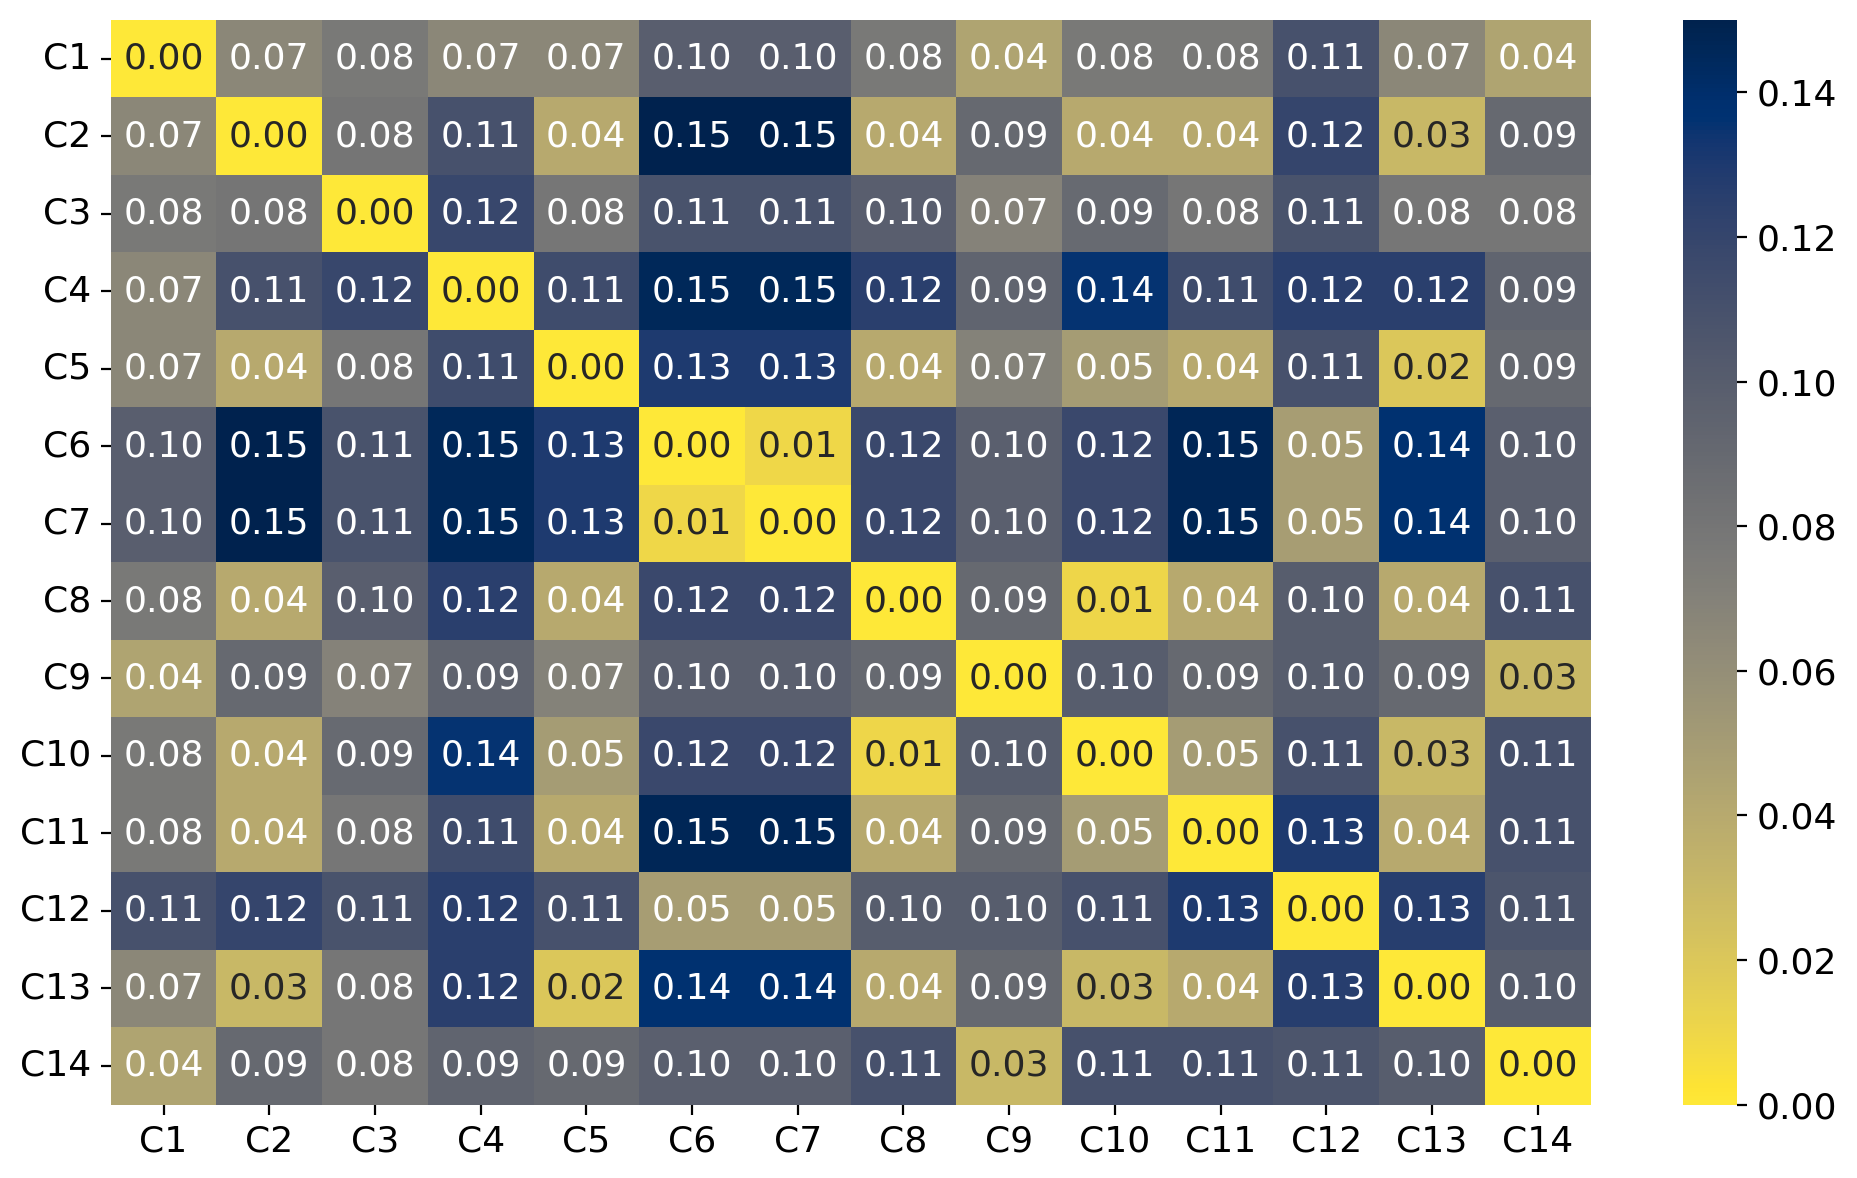

In [13]:
subsMat, syllable_segments, resampled_segments = get_matrix("ABD", "C1L1B7")

In [59]:
syllable = id_list[0]
syllable
syl_id_dict[syllable]

'जा1'

In [60]:
syl_id_dict

{'C1L1B7': 'जा1',
 'C1L2B9': 'जा2',
 'C1L2B11': 'रे',
 'C1L2B13': 'अ',
 'C1L2B14': 'प',
 'C1L2B15': 'ने',
 'C2L1B1': 'मं',
 'C2L1B3': 'दि1',
 'C2L1B4': 'र',
 'C2L1B5': 'वा'}

In [61]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def count_clusters(subsMat, threshold: float = 0.3) -> int:
    condensed = squareform(subsMat)
    Z = linkage(condensed, method='average')

    # Generate cluster labels
    cluster_labels = fcluster(Z, t=threshold, criterion='distance')
    num_clusters = len(np.unique(cluster_labels))

    return num_clusters

In [62]:
import json
pitchExpressiveness = {}

for artist in artists:
    sylExpList = []
    for sylID in id_list:
        # if artist == "SHS" and sylID == "C1L2B15":
        #     mean_upper_tri = 0
        #     std_upper_tri = 0

        #     print(upper_tri_elements, mean_upper_tri, std_upper_tri)
        #     sylExpList.append((mean_upper_tri, std_upper_tri))
        #     continue
            
        subsMat, syllable_segments, resampled_segments = get_matrix(artist, sylID)

        # Get indices for upper triangular part excluding diagonal
        upper_tri_indices = np.triu_indices_from(subsMat, k=1)

        # Extract those elements
        upper_tri_elements = subsMat[upper_tri_indices]

        # Compute mean and std deviation
        mean_upper_tri = np.mean(upper_tri_elements)
        std_upper_tri = np.std(upper_tri_elements)

        print(upper_tri_elements, mean_upper_tri, std_upper_tri)
        sylExpList.append((mean_upper_tri, std_upper_tri, count_clusters(subsMat, threshold=0.3)))

    pitchExpressiveness[artist] = sylExpList


ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s
[  0. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 200. 200. 200. 200. 200. 200. 300. 300. 300. 300. 300. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 500. 200. 200. -inf -inf -inf 300. 300.]
[500. 500. 500. 500. 500. 500. 500. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 900. 900. 900. 900. 900. 900. 900.
 9

In [63]:
# import json
# with open(r"D:\Desktop\MIR\ipynb notebooks\pitch_expression_matrix_ja_jare.json", 'r') as file:
#     pitchExpressiveness = json.load(file)

In [64]:
# import json
# with open("pitch_expression_matrix_ja_jare.json", 'w') as file:
#     json.dump(pitchExpressiveness, file, indent=4)

In [65]:
# MEAN
cleaned_data = {
    key: [t[0] for t in value]
    for key, value in pitchExpressiveness.items()
}

print(cleaned_data)

{'ABD': [0.08612333416320068, 0.014725274725274726, 0.03574488820606551, 0.028770006428558863, 0.0, 0.003152492668621701, 0.1337870655869641, 0.12272005772005772, 0.11641025641025639, 0.07245976666431213], 'AC': [0.09326201327615755, 0.0823396501457726, 0.06481639737563588, 0.08893679052381413, 0.0657250737459766, 0.021227316049406492, 0.0693879472693032, 0.05185185185185185, 0.11633218982275584, 0.12037406051529523], 'AK': [0.082, 0.04933333333333334, 0.05466731266149871, 0.1062593984962406, 0.09737745098039216, 0.05117073170731708, 0.027421052631578947, 0.1303636363636364, 0.15446723855748065, 0.14638144603934075], 'DG': [0.09562010648668823, 0.05405139778683751, 0.04336748022645459, 0.06631681828815655, 0.009247830156792296, 0.013390577077064056, 0.08882368232364006, 0.10165427133420213, 0.09735294117647059, 0.11322860962566844], 'IN': [0.08437170145647303, 0.0361904761904762, 0.06784166748809636, 0.060119892939067124, 0.04849805188864537, 0.0, 0.025882107459572246, 0.01866666666666

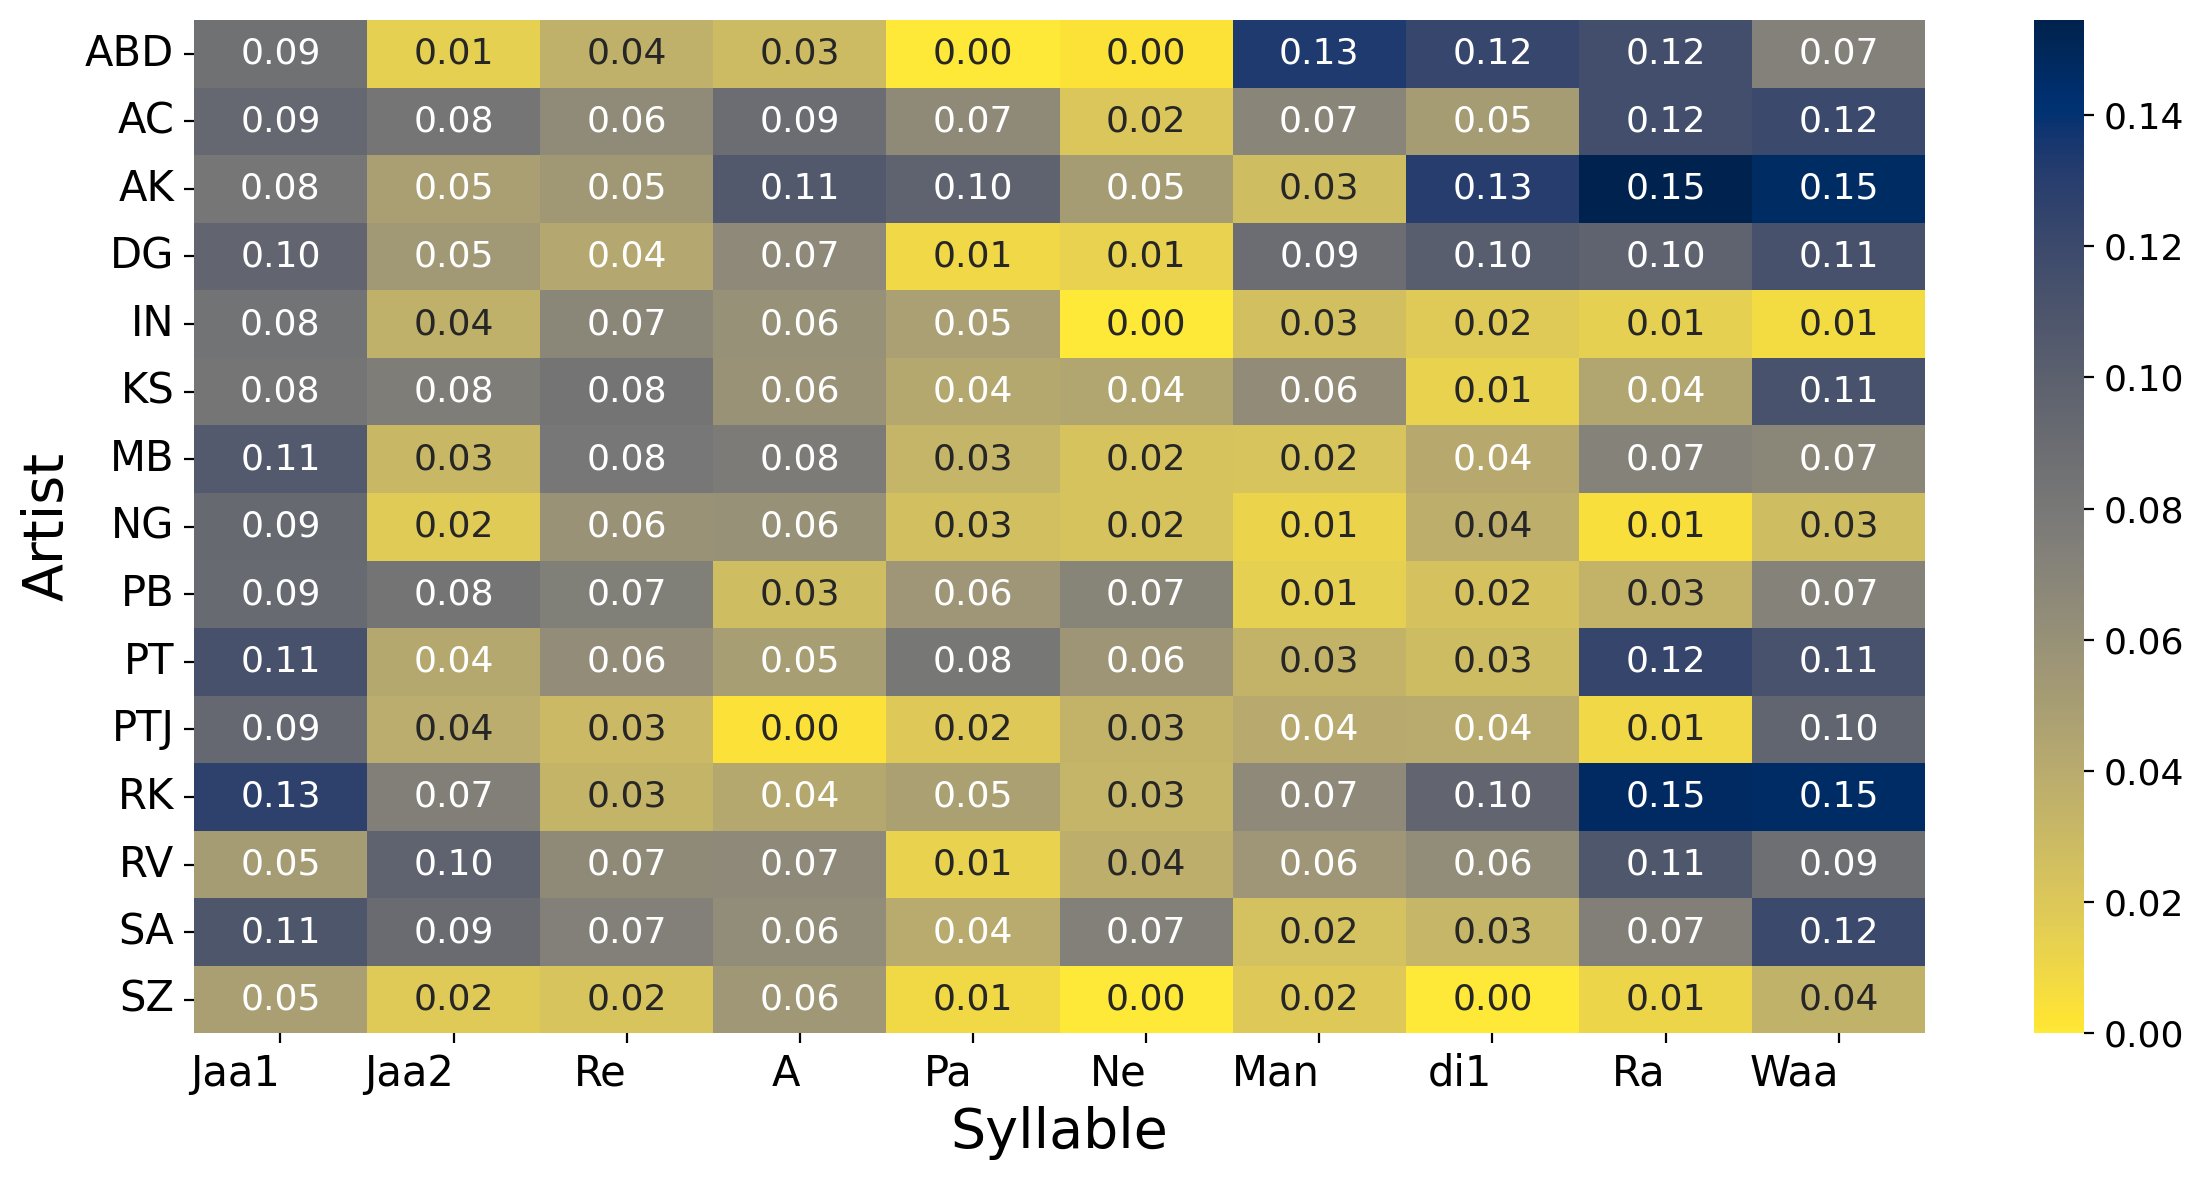

In [ ]:

def plot_syllable_heatmap(data_dict):
    syllables = syl_list
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=[eng_dict[syl] for syl in syllables])

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap="cividis_r",
        annot_kws={"size": 13}  # <- Increase font size of numbers inside heatmap
    )

    # Set axis labels
    plt.xlabel("Syllable", fontsize=20)
    plt.ylabel("Artist", fontsize=20)
    plt.yticks(rotation=0, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', size=15)

    # Increase colorbar tick label font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)  # <- Font size for colorbar ticks

    plt.tight_layout()
    plt.show()


plot_syllable_heatmap(cleaned_data)


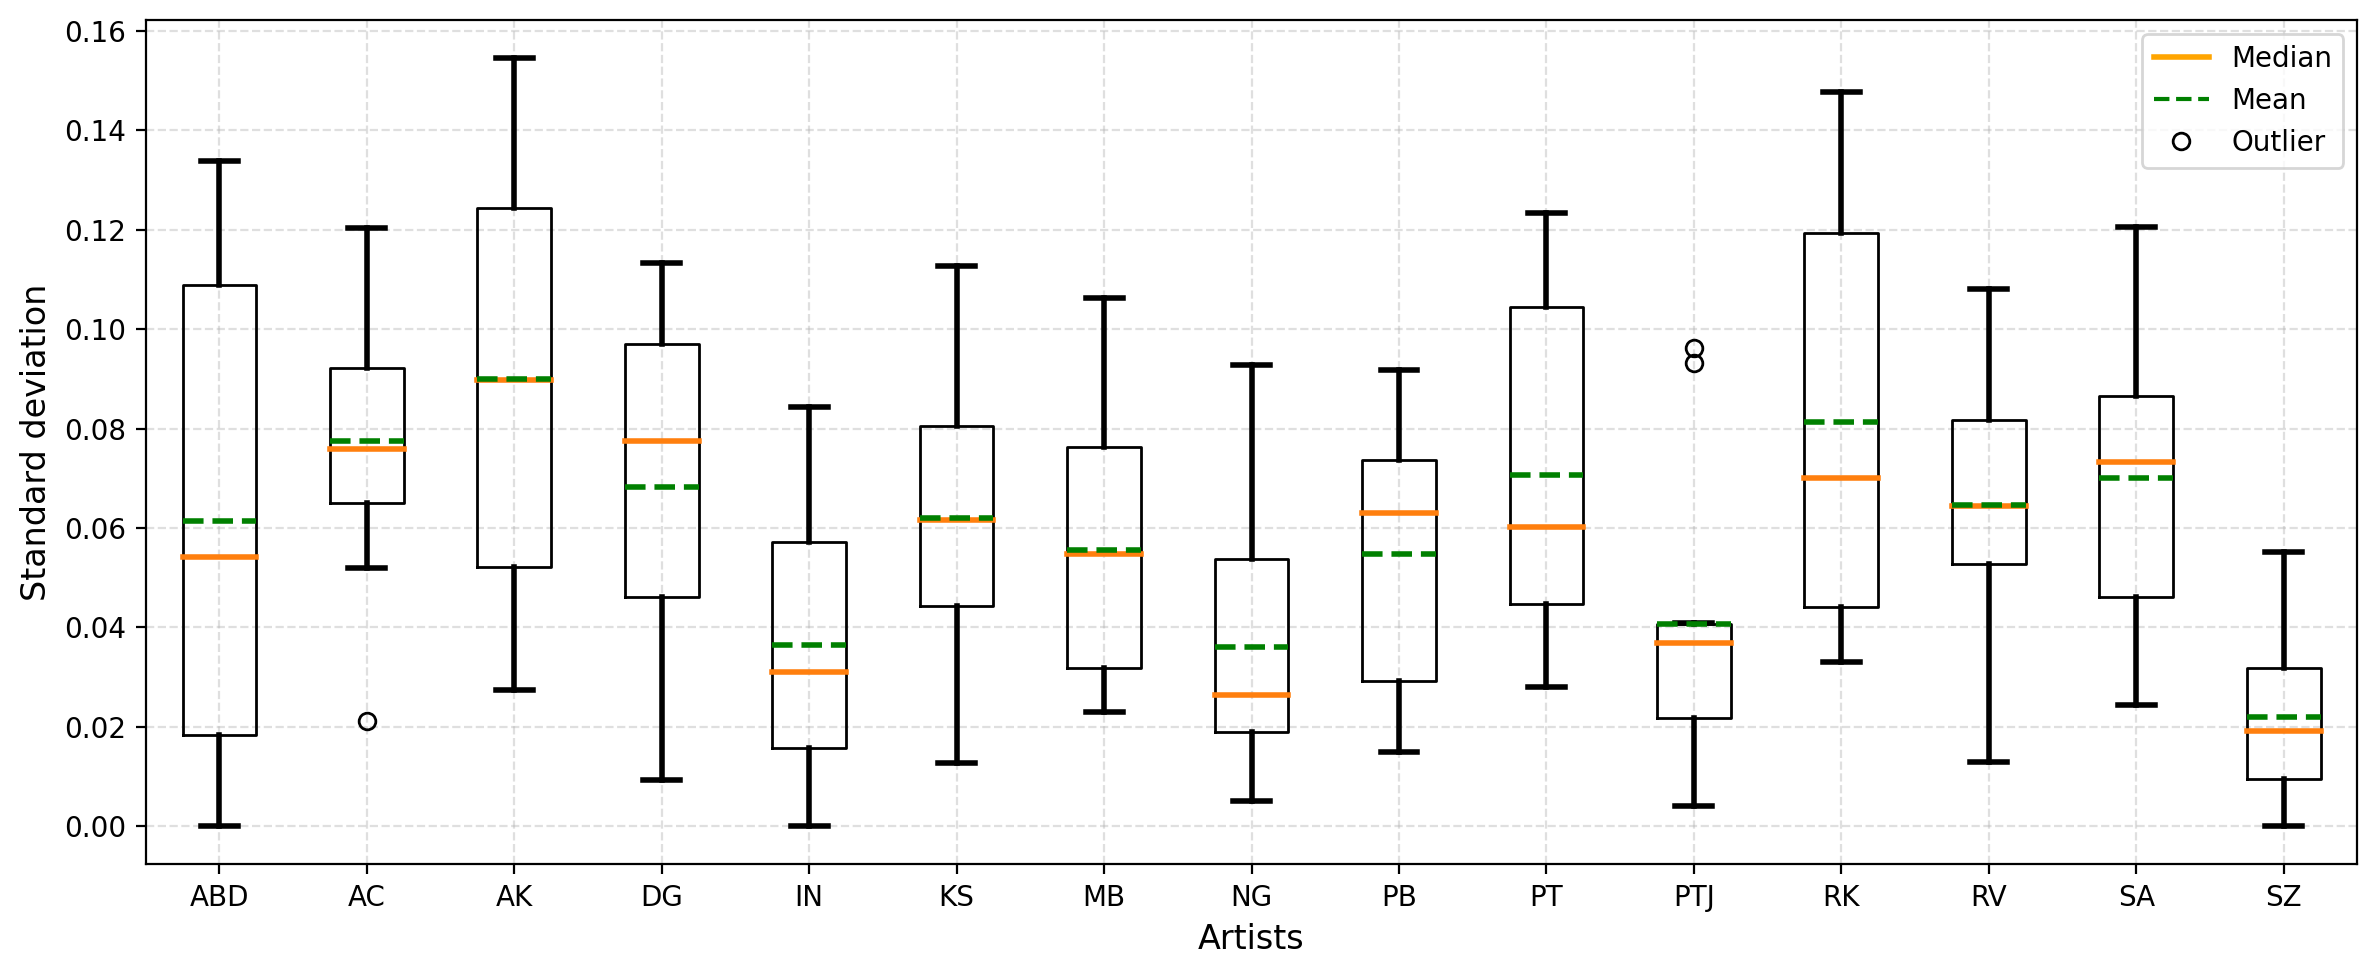

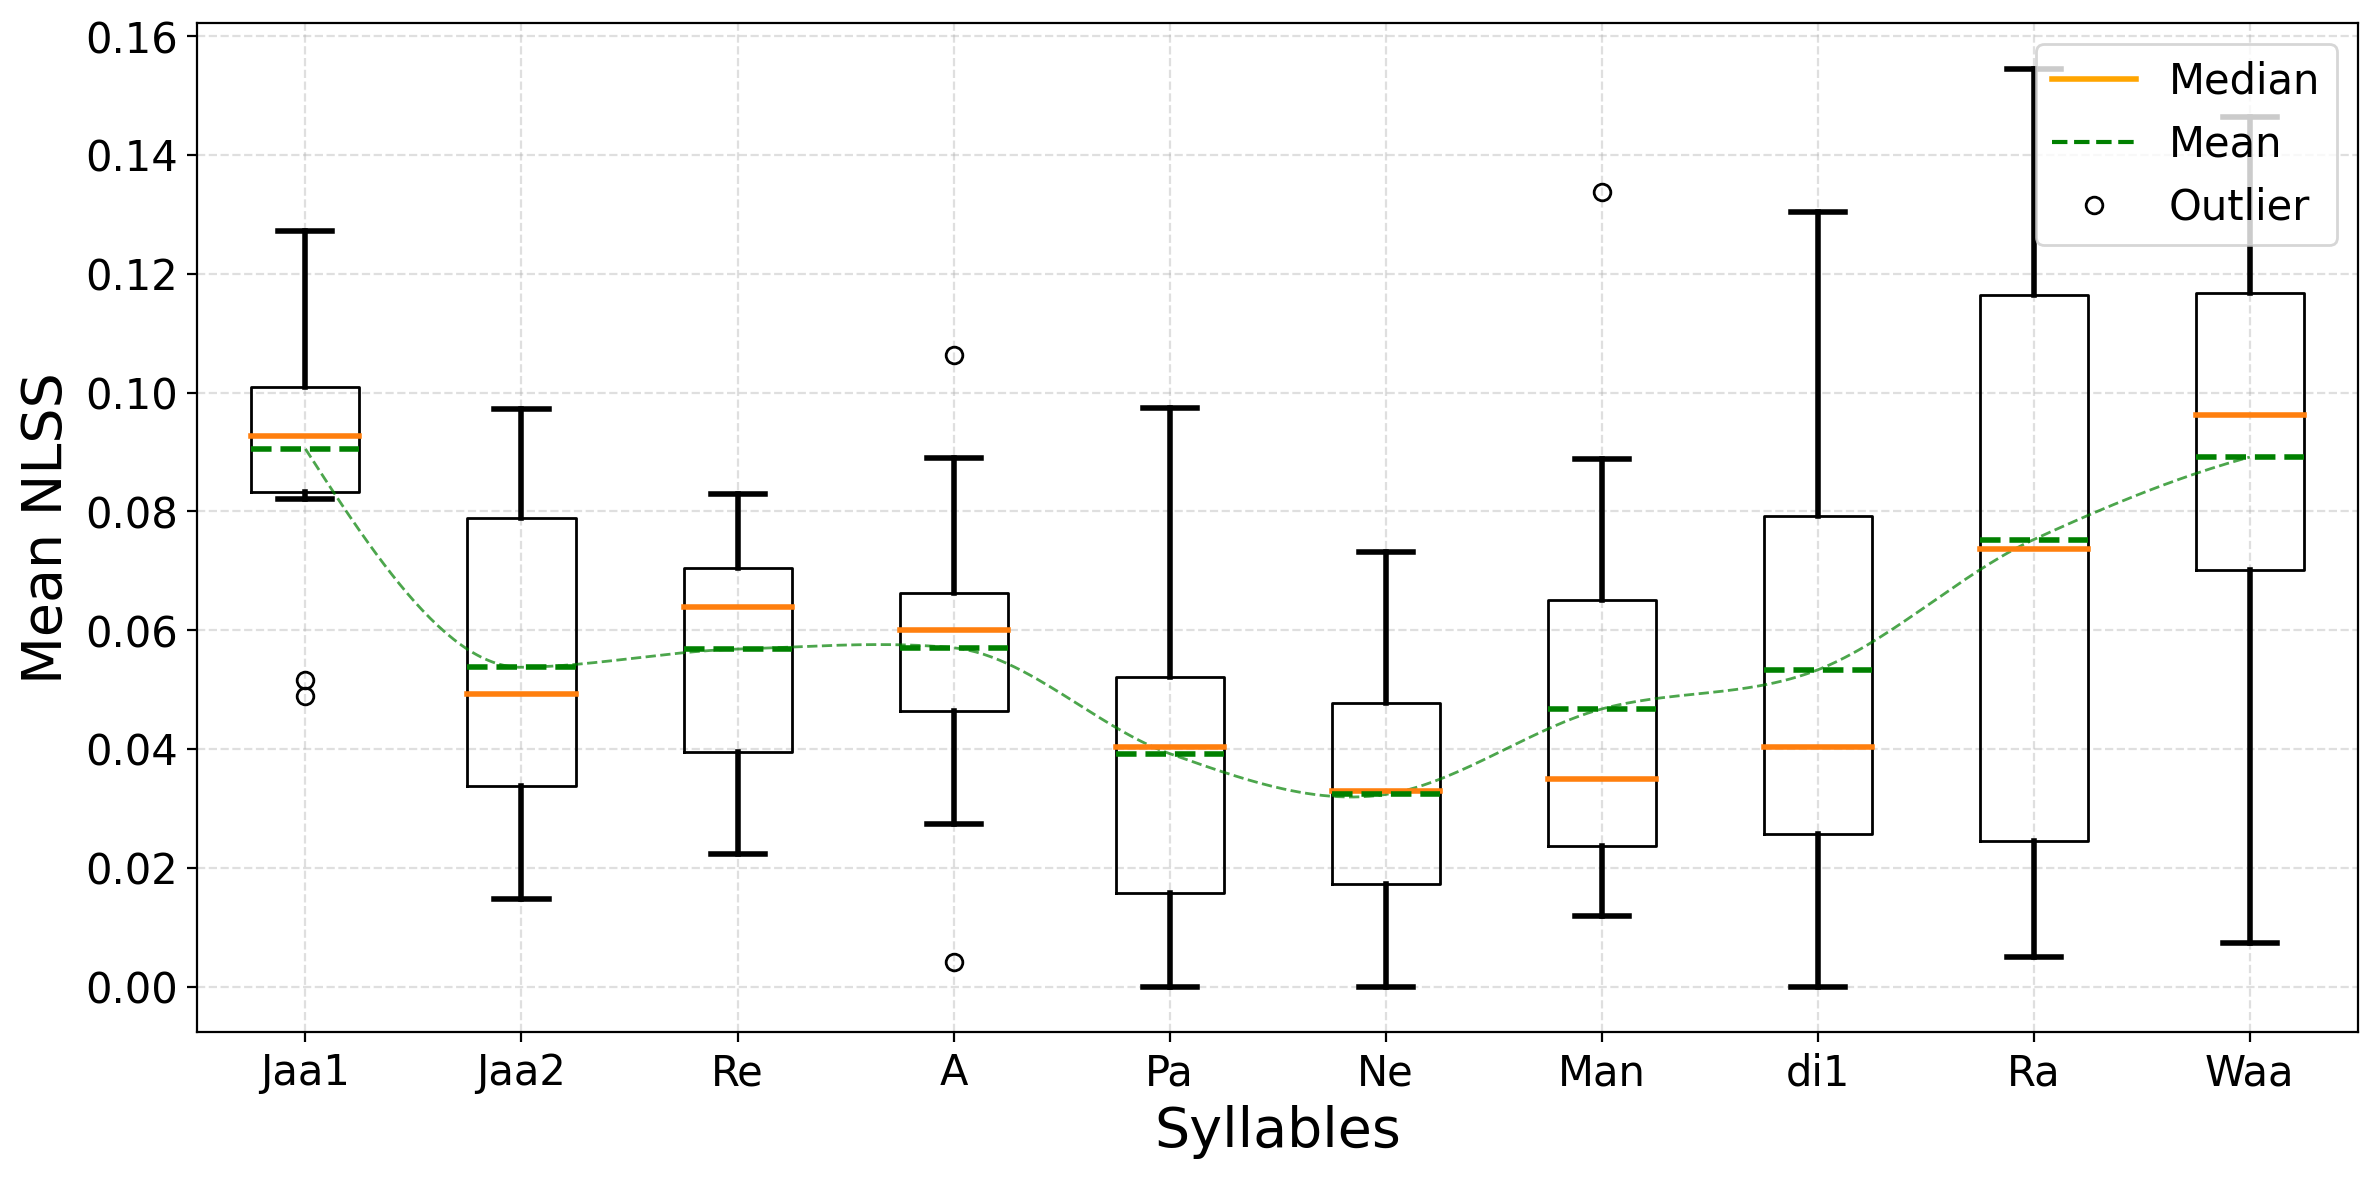

In [ ]:
def box_plots(data):

    artist_names = list(data.keys())
    matrix = np.array(list(data.values()))  # Shape: (15, 10)

    # --- Boxplot 1: Across artists (each artist's distribution of 10 syllables) ---
    plt.figure(figsize=(12, 5))
    plt.boxplot(
        matrix.T,
        labels=artist_names,
        showfliers=True,
        meanline=True,
        showmeans=True,
        boxprops=dict(linewidth=1),
        medianprops=dict(linewidth=2),
        whiskerprops=dict(linewidth=2),
        capprops=dict(linewidth=2),
        meanprops=dict(linewidth=2, color='green')  # for mean lines
    )

    # plt.title("Distribution Across Artists")
    plt.xlabel("Artists", fontsize=12)
    plt.ylabel("Standard deviation", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)

        # Custom legend handles
    legend_elements = [
        Line2D([0], [0], color='orange', lw=2, label='Median'),
        Line2D([0], [0], color='green', linestyle='--', label='Mean'),
        Line2D([0], [0], linestyle='none', marker='o', markerfacecolor='none', markeredgecolor='black', label='Outlier', markersize=6)
    ]

    plt.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.show()

    # --- Boxplot 2: Across syllables (distribution per syllable across artists) ---
    plt.figure(figsize=(12, 6))
    syllable_labels = [f"Syl{i+1}" for i in range(matrix.shape[1])]
    plt.boxplot(
        matrix,
        labels=[eng_dict[syl] for syl in syl_list],
        showfliers=True,
        meanline=True,
        showmeans=True,
        boxprops=dict(linewidth=1),
        medianprops=dict(linewidth=2),
        whiskerprops=dict(linewidth=2),
        capprops=dict(linewidth=2),
        meanprops=dict(linewidth=2, color='green')  # for mean lines
    )
    # Compute artist-wise mean across syllables
    mean_vals = np.mean(matrix.T, axis=1)
    x_coords = np.arange(1, len(mean_vals) + 1)

    # Akima interpolation for the means
    akima = Akima1DInterpolator(x_coords, mean_vals)
    x_dense = np.linspace(1, len(mean_vals), 500)
    y_dense = akima(x_dense)
    plt.plot(x_dense, y_dense, linestyle='--', color='green', linewidth=1, label='Akima Mean Curve', alpha = 0.7)
    # plt.title("Distribution Across Syllables")
    plt.xlabel("Syllables", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Mean NLSS", fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.legend(handles=legend_elements, loc='upper right', fontsize=15)
    plt.tight_layout()
    plt.show()


box_plots(cleaned_data)